In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing    
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance

In [3]:
train_df = pd.read_csv('../input/spaceship-titanic/train.csv')
test_df  = pd.read_csv('../input/spaceship-titanic/test.csv')

In [4]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<AxesSubplot:xlabel='FoodCourt'>

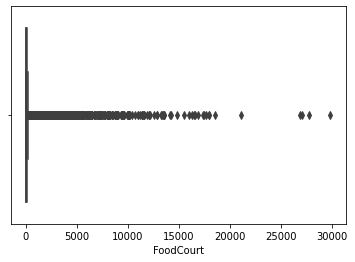

In [6]:
sns.boxplot(x='FoodCourt',data=train_df)

In [7]:
train_df.loc[train_df['FoodCourt'] > 20000, 'FoodCourt'] = train_df.loc[train_df['FoodCourt'] < 20000, 'FoodCourt'].mean()

<AxesSubplot:xlabel='Transported', ylabel='ShoppingMall'>

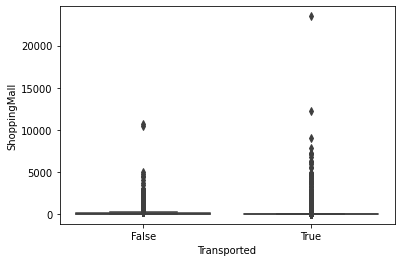

In [8]:
sns.boxplot(x='Transported', y='ShoppingMall',data=train_df)

In [9]:
train_df.loc[train_df['ShoppingMall'] > 10000, 'ShoppingMall'] = train_df.loc[train_df['ShoppingMall'] < 10000, 'ShoppingMall'].mean()

<AxesSubplot:xlabel='Spa'>

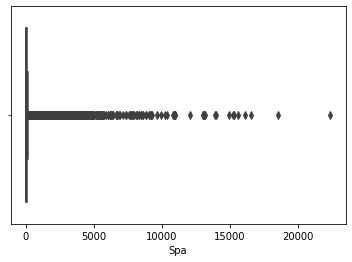

In [10]:
sns.boxplot(x='Spa',data=train_df)

In [11]:
train_df.loc[train_df['Spa'] > 20000, 'Spa'] = train_df.loc[train_df['Spa'] < 20000, 'Spa'].mean()

<AxesSubplot:xlabel='VRDeck'>

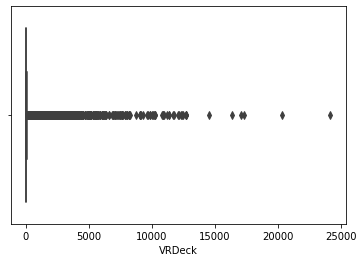

In [12]:
sns.boxplot(x='VRDeck',data=train_df)

In [13]:
train_df.loc[train_df['VRDeck'] > 20000, 'VRDeck'] = train_df.loc[train_df['VRDeck'] < 20000, 'VRDeck'].mean()

<AxesSubplot:xlabel='RoomService'>

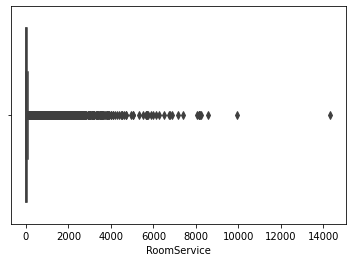

In [14]:
sns.boxplot(x='RoomService',data=train_df)

In [15]:
train_df.loc[train_df['RoomService'] > 10000, 'RoomService'] = train_df.loc[train_df['RoomService'] < 10000, 'RoomService'].mean()

In [16]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [17]:
train_df[['Group','ID']]=train_df['PassengerId'].str.split('_',expand=True)
train_df['Group'].astype('int8')

test_df[['Group','ID']]=test_df['PassengerId'].str.split('_',expand=True)
test_df['Group'].astype('int8')




0       13
1       18
2       19
3       21
4       23
        ..
4272    50
4273    53
4274    55
4275    57
4276    61
Name: Group, Length: 4277, dtype: int8

In [18]:
# for group in train_df[train_df.HomePlanet.isnull()].Group.value_counts().index:
#     print(group, train_df[train_df.Group == group].HomePlanet.unique()[0])
  
train_df.HomePlanet.fillna('?', inplace=True)

test_df.HomePlanet.fillna('?', inplace=True)


In [19]:
home_grp_mapping = {
    
}

for group in train_df[train_df.HomePlanet == "?"].Group.value_counts().index:
    if len(train_df[train_df.Group == group].HomePlanet.unique()) > 1:
        unq = list(train_df[train_df.Group == group].HomePlanet.unique())
        unq.remove('?')
        home_grp_mapping[group] = unq[0]
    
home_grp_mapping1 = {
    
}

for group in test_df[test_df.HomePlanet == "?"].Group.value_counts().index:
    if len(test_df[test_df.Group == group].HomePlanet.unique()) > 1:
        unq1 = list(test_df[test_df.Group == group].HomePlanet.unique())
        unq1.remove('?')
        home_grp_mapping1[group] = unq1[0]

In [20]:
for group_id in home_grp_mapping.keys():
  train_df.loc[train_df["Group"] == group_id, "HomePlanet"] = home_grp_mapping[group_id]
for group_id in home_grp_mapping1.keys():
  test_df.loc[test_df["Group"] == group_id, "HomePlanet"] = home_grp_mapping1[group_id]

In [21]:
train_df.HomePlanet.value_counts(dropna=False)
test_df.HomePlanet.value_counts(dropna=False)

Earth     2280
Europa    1014
Mars       937
?           46
Name: HomePlanet, dtype: int64

In [22]:
train_df['HomePlanet'].replace(to_replace="?",
           value=np.nan,inplace=True)
train_df.HomePlanet.fillna(method='ffill',inplace=True)

test_df['HomePlanet'].replace(to_replace="?",
           value=np.nan,inplace=True)
test_df.HomePlanet.fillna(method='ffill',inplace=True)

In [23]:
train_df.Cabin.fillna('?', inplace=True)
cabin_grp_mapping={
    
}
for group in train_df[train_df.Cabin == "?"].Group.value_counts().index:
    if len(train_df[train_df.Group == group].Cabin.unique()) > 1:
        cab= list(train_df[train_df.Group == group].Cabin.unique())
        cab.remove('?')
        cabin_grp_mapping[group] = cab[0]

test_df.Cabin.fillna('?', inplace=True)
cabin_grp_mapping1={
    
}
for group in test_df[test_df.Cabin == "?"].Group.value_counts().index:
    if len(test_df[test_df.Group == group].Cabin.unique()) > 1:
        cab1= list(test_df[test_df.Group == group].Cabin.unique())
        cab1.remove('?')
        cabin_grp_mapping1[group] = cab1[0]

In [24]:
for group_id in cabin_grp_mapping.keys():
  train_df.loc[train_df["Group"] == group_id, "Cabin"] = cabin_grp_mapping[group_id]

for group_id in cabin_grp_mapping1.keys():
  test_df.loc[test_df["Group"] == group_id, "Cabin"] = cabin_grp_mapping1[group_id]

In [25]:
train_df.Cabin.value_counts()
test_df.Cabin.value_counts()

?           63
G/160/P      8
E/232/S      7
D/273/S      7
B/31/P       7
            ..
G/566/P      1
G/557/S      1
G/559/S      1
F/651/S      1
G/1498/S     1
Name: Cabin, Length: 3260, dtype: int64

In [26]:
train_df['Cabin'].replace(to_replace="?",
           value=np.nan,inplace=True)
train_df.Cabin.fillna(method='ffill',inplace=True)


test_df['Cabin'].replace(to_replace="?",
           value=np.nan,inplace=True)
test_df.Cabin.fillna(method='ffill',inplace=True)

In [27]:
train_df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin             0
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
ID                0
dtype: int64

In [28]:
test_df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep        93
Cabin             0
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
Group             0
ID                0
dtype: int64

In [29]:
train_df.Destination.fillna('find',inplace=True)
test_df.Destination.fillna('find',inplace=True)

In [30]:
dest_grp_mapping={
    
}
for group in train_df[train_df.Destination == "find"].Group.value_counts().index:
    if len(train_df[train_df.Group == group].Destination.unique()) > 1:
        des= list(train_df[train_df.Group == group].Destination.unique())
        des.remove('find')
        dest_grp_mapping[group] = des[0]
        
dest_grp_mapping1={
    
}
for group in test_df[test_df.Destination == "find"].Group.value_counts().index:
    if len(test_df[test_df.Group == group].Destination.unique()) > 1:
        des1= list(test_df[test_df.Group == group].Destination.unique())
        des1.remove('find')
        dest_grp_mapping1[group] = des[0]

In [31]:
for group_id in dest_grp_mapping1.keys():
  train_df.loc[train_df["Group"] == group_id, "Destination"] = dest_grp_mapping1[group_id]

In [32]:
train_df.Destination.value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
find              182
Name: Destination, dtype: int64

In [33]:
train_df['Destination'].replace(to_replace="find",
           value=np.nan,inplace=True)
train_df.Destination.fillna(method='ffill',inplace=True)

test_df['Destination'].replace(to_replace="find",
           value=np.nan,inplace=True)
test_df.Destination.fillna(method='ffill',inplace=True)

<AxesSubplot:xlabel='Age'>

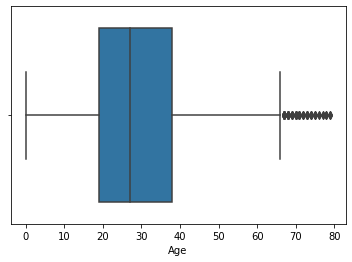

In [34]:
sns.boxplot(x='Age',data=train_df)

In [35]:
train_df.Age.fillna(train_df['Age'].mean(),inplace=True)

test_df.Age.fillna(test_df['Age'].mean(),inplace=True)

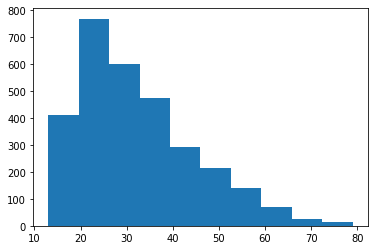

In [36]:
plt.hist(train_df['Age'].loc[train_df['VRDeck']>0])
plt.show() 

In [37]:
train_df.ShoppingMall.fillna('fill',inplace=True)
train_df.VRDeck.fillna('fill',inplace=True)
train_df.RoomService.fillna('fill',inplace=True)
train_df.Spa.fillna('fill',inplace=True)
train_df.FoodCourt.fillna('fill',inplace=True)


test_df.ShoppingMall.fillna('fill',inplace=True)
test_df.VRDeck.fillna('fill',inplace=True)
test_df.RoomService.fillna('fill',inplace=True)
test_df.Spa.fillna('fill',inplace=True)
test_df.FoodCourt.fillna('fill',inplace=True)

In [38]:
for i,sleep in enumerate(train_df['ShoppingMall'].loc[train_df['CryoSleep']==True]):
    if train_df.loc[i,'ShoppingMall']=='fill':
        train_df.at[i,'ShoppingMall']=0.0
for i,sleep in enumerate(train_df['VRDeck'].loc[train_df['CryoSleep']==True]):
    if train_df.loc[i,'VRDeck']=='fill':
        train_df.at[i,'VRDeck']=0.0
for i,sleep in enumerate(train_df['RoomService'].loc[train_df['CryoSleep']==True]):
    if train_df.loc[i,'RoomService']=='fill':
        train_df.at[i,'RoomService']=0.0
for i,sleep in enumerate(train_df['Spa'].loc[train_df['CryoSleep']==True]):
    if train_df.loc[i,'Spa']=='fill':
        train_df.at[i,'Spa']=0.0
for i,sleep in enumerate(train_df['FoodCourt'].loc[train_df['CryoSleep']==True]):
    if train_df.loc[i,'FoodCourt']=='fill':
        train_df.at[i,'FoodCourt']=0.0
        
        

for i,sleep in enumerate(test_df['ShoppingMall'].loc[test_df['CryoSleep']==True]):
    if test_df.loc[i,'ShoppingMall']=='fill':
        test_df.at[i,'ShoppingMall']=0.0
for i,sleep in enumerate(test_df['VRDeck'].loc[test_df['CryoSleep']==True]):
    if test_df.loc[i,'VRDeck']=='fill':
        test_df.at[i,'VRDeck']=0.0
for i,sleep in enumerate(test_df['RoomService'].loc[test_df['CryoSleep']==True]):
    if test_df.loc[i,'RoomService']=='fill':
        test_df.at[i,'RoomService']=0.0
for i,sleep in enumerate(test_df['Spa'].loc[test_df['CryoSleep']==True]):
    if test_df.loc[i,'Spa']=='fill':
        test_df.at[i,'Spa']=0.0
for i,sleep in enumerate(test_df['FoodCourt'].loc[test_df['CryoSleep']==True]):
    if test_df.loc[i,'FoodCourt']=='fill':
        test_df.at[i,'FoodCourt']=0.0

In [39]:
train_df.ShoppingMall.loc[train_df['ShoppingMall']=='fill'].count()

128

In [40]:
train_df['ShoppingMall'].replace(to_replace="fill",
           value=np.nan,inplace=True)
train_df['VRDeck'].replace(to_replace="fill",
           value=np.nan,inplace=True)
train_df['FoodCourt'].replace(to_replace="fill",
           value=np.nan,inplace=True)
train_df['Spa'].replace(to_replace="fill",
           value=np.nan,inplace=True)
train_df['RoomService'].replace(to_replace="fill",
           value=np.nan,inplace=True)


test_df['ShoppingMall'].replace(to_replace="fill",
           value=np.nan,inplace=True)
test_df['VRDeck'].replace(to_replace="fill",
           value=np.nan,inplace=True)
test_df['FoodCourt'].replace(to_replace="fill",
            value=np.nan,inplace=True)
test_df['Spa'].replace(to_replace="fill",
           value=np.nan,inplace=True)
test_df['RoomService'].replace(to_replace="fill",
           value=np.nan,inplace=True)

In [41]:
train_df.ShoppingMall.fillna(method='ffill',inplace=True)
train_df.VRDeck.fillna(method='ffill',inplace=True)
train_df.FoodCourt.fillna(method='ffill',inplace=True)
train_df.Spa.fillna(method='ffill',inplace=True)
train_df.RoomService.fillna(method='ffill',inplace=True)


test_df.ShoppingMall.fillna(method='ffill',inplace=True)
test_df.VRDeck.fillna(method='ffill',inplace=True)
test_df.FoodCourt.fillna(method='ffill',inplace=True)
test_df.Spa.fillna(method='ffill',inplace=True)
test_df.RoomService.fillna(method='ffill',inplace=True)

In [42]:
train_df['Total_expenses']=train_df['RoomService']+train_df['FoodCourt']+train_df['ShoppingMall']+train_df['Spa']+train_df['VRDeck']
test_df['Total_expenses']=test_df['RoomService']+test_df['FoodCourt']+test_df['ShoppingMall']+test_df['Spa']+test_df['VRDeck']

In [43]:
train_df.CryoSleep.fillna('fill',inplace=True)
test_df.CryoSleep.fillna('fill',inplace=True)


In [44]:
train_df['CryoSleep'].value_counts()

False    5439
True     3037
fill      217
Name: CryoSleep, dtype: int64

In [45]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,ID,Total_expenses
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,1091.0


In [46]:
for i,sleep in enumerate(train_df['CryoSleep'].loc[train_df['Total_expenses']==0]):
    if train_df.loc[i,'CryoSleep']=='fill':
        train_df.at[i,'CryoSleep']=True
        
        
for i,sleep in enumerate(test_df['CryoSleep'].loc[test_df['Total_expenses']==0]):
    if test_df.loc[i,'CryoSleep']=='fill':
        test_df.at[i,'CryoSleep']=True

In [47]:
train_df['CryoSleep'].replace(to_replace="fill",
           value=False,inplace=True)


test_df['CryoSleep'].replace(to_replace="fill",
           value=False,inplace=True)

In [48]:
train_df['CryoSleep'].value_counts(dropna=False)

test_df['CryoSleep'].value_counts(dropna=False)


False    2700
True     1577
Name: CryoSleep, dtype: int64

In [49]:
train_df['VIP'].fillna(False,inplace=True)

test_df['VIP'].fillna(False,inplace=True)


In [50]:
train_df.isnull().sum()

PassengerId         0
HomePlanet          0
CryoSleep           0
Cabin               0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
Name              200
Transported         0
Group               0
ID                  0
Total_expenses      0
dtype: int64

In [51]:
train_df[['DeckName','DeckNumber','DeckSide']]=train_df['Cabin'].str.split('/',expand=True)
test_df[['DeckName','DeckNumber','DeckSide']]=train_df['Cabin'].str.split('/',expand=True)

In [52]:
train_df.Destination.value_counts()

TRAPPIST-1e      6037
55 Cancri e      1840
PSO J318.5-22     816
Name: Destination, dtype: int64

In [53]:
le = preprocessing.LabelEncoder()
def converting_column(df,col,convertType):
    if convertType=='OHE':
        one_hot = pd.get_dummies(df[col],prefix=col)
        df = df.drop(col,axis = 1)
        df = df.join(one_hot)
        return df
    else:
        df[col] = le.fit_transform(df[col])
        return df

In [54]:
train_df = converting_column(train_df,'HomePlanet','OHE')
test_df = converting_column(test_df,'HomePlanet','OHE')

In [55]:
train_df = converting_column(train_df,'Destination','FTR')
test_df = converting_column(test_df,'Destination','FTR')

In [56]:
train_df = converting_column(train_df,'CryoSleep','FTR')
test_df = converting_column(test_df,'CryoSleep','FTR')

In [57]:
train_df = converting_column(train_df,'VIP','FTR')
test_df = converting_column(test_df,'VIP','FTR')

In [58]:
train_df.head()

,PassengerId,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,...,Transported,Group,ID,Total_expenses,DeckName,DeckNumber,DeckSide,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars
0,0001_01,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,...,False,0001,01,0.0,B,0,P,0,1,0
1,0002_01,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,...,True,0002,01,736.0,F,0,S,1,0,0
2,0003_01,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,...,False,0003,01,10383.0,A,0,S,0,1,0
3,0003_02,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,...,False,0003,02,5176.0,A,0,S,0,1,0
4,0004_01,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,...,True,0004,01,1091.0,F,1,S,1,0,0


In [59]:
train_df['DeckName'] = le.fit_transform(train_df['DeckName'])
train_df['DeckSide'] = le.fit_transform(train_df['DeckSide'])
test_df['DeckName'] = le.fit_transform(test_df['DeckName'])
test_df['DeckSide'] = le.fit_transform(test_df['DeckSide'])

In [60]:
train_df.drop(['PassengerId','Cabin','HomePlanet_Earth','HomePlanet_Europa','HomePlanet_Mars','DeckNumber','Name','Total_expenses','Group','ID'],axis=1,inplace=True)


In [61]:
test_df.drop(['PassengerId','Cabin','HomePlanet_Earth','HomePlanet_Europa','HomePlanet_Mars','DeckNumber','Name','Total_expenses','Group','ID'],axis=1,inplace=True)

In [62]:
x_train= train_df.drop("Transported", axis=1)
y_train= train_df["Transported"]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.33, random_state =45)

In [63]:
test_df.head()

,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,DeckName,DeckSide
0,1,2,27.0,0,0.0,0.0,0.0,0.0,0.0,1,0
1,0,2,19.0,0,0.0,9.0,0.0,2823.0,0.0,5,1
2,1,0,31.0,0,0.0,0.0,0.0,0.0,0.0,0,1
3,0,2,38.0,0,0.0,6652.0,0.0,181.0,585.0,0,1
4,0,2,20.0,0,10.0,0.0,635.0,0.0,0.0,5,1


In [64]:
train_df.head()

,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,DeckName,DeckSide
0,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False,1,0
1,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True,5,1
2,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,0,1
3,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,0,1
4,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True,5,1


In [65]:
# params = {'learning_rate': 0.29,
#           'min_child_weight': 0.27,
#           'gamma': 0.1,
#           'subsample': 0.95,
#           'colsample_bytree': 0.55,
#           'colsample_bylevel': 0.55,
#           'max_depth': 4,
#           'n_estimators': 100,
#           'reg_lambda': 2.25,
#           'monotone_constraints': '(0, -1)',
#           'use_label_encoder': False
#           }
# xgb_model = XGBClassifier()
# xgb_model.set_params(gamma = 2.5,
#                     subsample = 1.0,
#                     max_depth = 5,
#                     colsample_bytree = 1.0,
#                     n_estimators = 100)
# mod = xgb_model.fit(X_train, Y_train,eval_metric='logloss')

# print("Performance on train data:", mod.score(X_train, Y_train))
# print(mod.score(X_test,Y_test))

In [66]:
import lightgbm as lgb
lbg = lgb.LGBMClassifier()
lbg.fit(X_train, Y_train)
print("score on test: " + str(lbg.score(X_test, Y_test)))
print("score on train: "+ str(lbg.score(X_train, Y_train)))

score on test: 0.8089926803764378
score on train: 0.8653846153846154


In [67]:
Y_pred =lbg.predict(test_df) == True
submission=pd.read_csv('../input/spaceship-titanic/sample_submission.csv')
submission['Transported'] = Y_pred
submission.to_csv('submission.csv', index=False)

In [68]:
submission.head(20)


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True
